#               **Repository of the implementation of popular Quantum Algorithms in Qiskit**

*Essential* *installations*

In [47]:
%pip install qiskit
%pip install qiskit-aer
%pip install qiskit-algorithms
%pip install 'qiskit[visualization]'

**Quantum Fourier Transforms (QFTs)**

In [48]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit.library import QFT
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

*This shows implementing Quantum Fourier Transform using qiskit's in-built QFT function*

/tmp/ipython-input-49-3196391786.py:2: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qc = QFT(


Circuit Diagram:


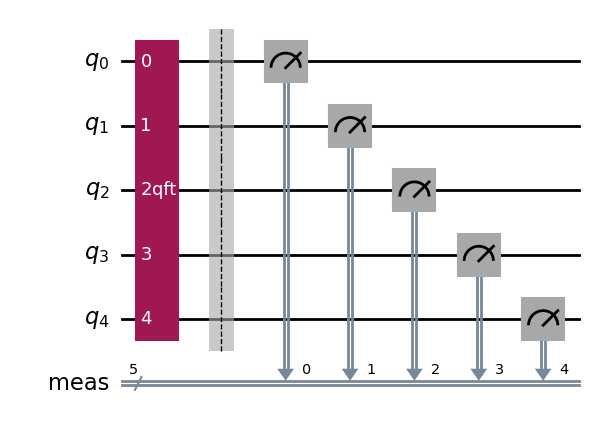


Measurement Results:


In [49]:
# Create 5-qubit QFT circuit
qc = QFT(
    num_qubits=5,
    approximation_degree=0,       # No approximation (exact QFT)
    do_swaps=True,                # Include swap gates
    inverse=False,                # Forward QFT (not inverse)
    insert_barriers=True,         # Visual separation in circuit diagram
    name='qft'                    # Circuit name
)

# Add measurement to all qubits
qc.measure_all()

# Setup simulator backend
backend = Aer.get_backend('aer_simulator')

# Transpile circuit for backend optimization
tqc = transpile(qc, backend)

# Execute circuit
job = backend.run(tqc, shots=1024)
result = job.result()
counts = result.get_counts()

# Visualization
print("Circuit Diagram:")
display(qc.draw('mpl', fold=-1))  # Circuit visualization

print("\nMeasurement Results:")
plot_histogram(counts)             # Results histogram
plt.show()


*This does not explicitly show how the Quantum Fourier Transformation works, we can also explicitly make our own QFT in the reverse order(for simplicity) and swap the qubits in the end*

QFT Circuit with swap gates for reversing:


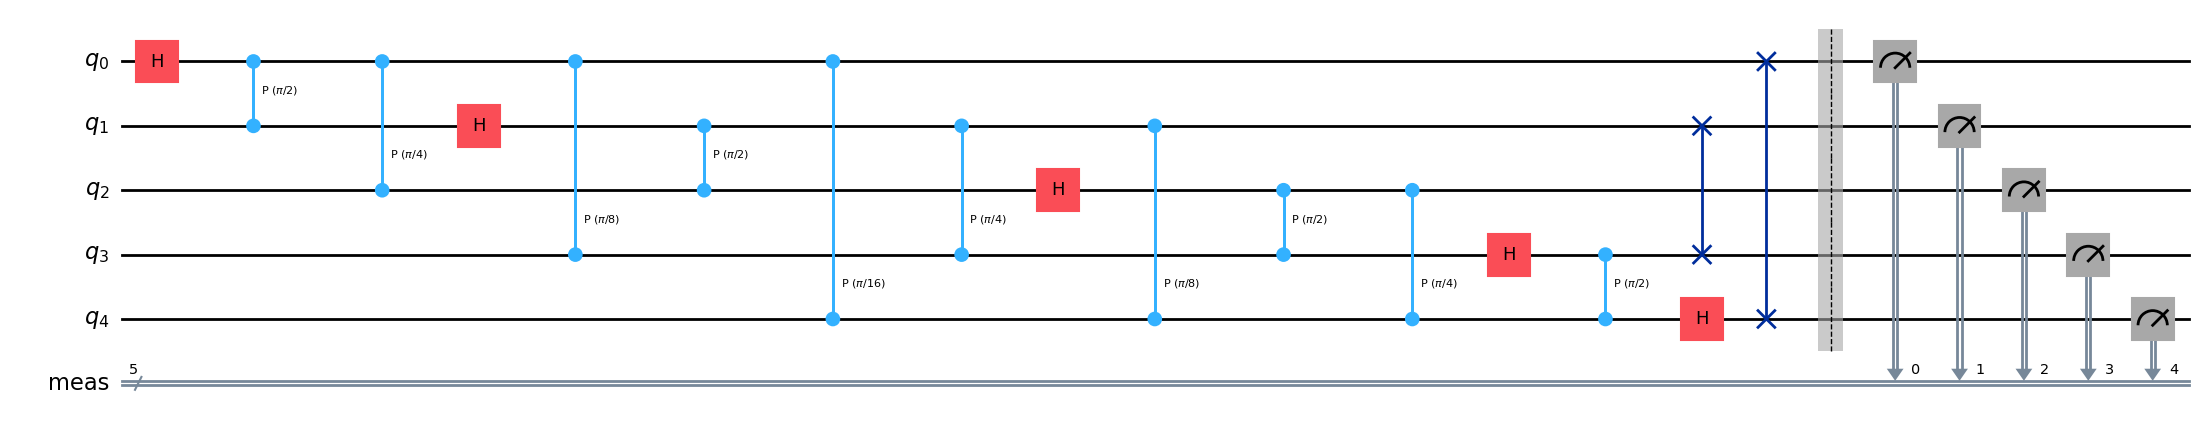


Measurement Results:


<Figure size 640x480 with 0 Axes>

In [50]:
import numpy as np
from qiskit_aer import AerSimulator


def myQFT(nqubits):
    qc = QuantumCircuit(nqubits)
    pi = np.pi
    # Apply QFT gates in order (0 to n-1)
    for qubit in range(nqubits):
        qc.h(qubit)
        for otherqubit in range(qubit + 1, nqubits):
            qc.cp(pi / (2**(otherqubit - qubit)), otherqubit, qubit)
    # Add swap gates to reverse qubit order
    for qubit in range(nqubits // 2):
        qc.swap(qubit, nqubits - qubit - 1)
    return qc

# Example usage for 5 qubits
n = 5
qft_circuit = myQFT(n)
qft_circuit.measure_all()
print("QFT Circuit with swap gates for reversing:")
display(qft_circuit.draw('mpl', fold=-1))

# Simulate and visualize results
simulator = AerSimulator()
job = simulator.run(qft_circuit, shots=1024)
result = job.result()
counts = result.get_counts()
print("\nMeasurement Results:")


plot_histogram(counts)
plt.savefig("test.png")



**Grover's Algorithm for unstructured search**

Grover's Algorithm Circuit with barriers to distinguish oracle and diffusion:


/tmp/ipython-input-51-1266490055.py:14: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(control_qubits=list(range(n_data)),
/tmp/ipython-input-51-1266490055.py:33: DeprecationWarning: ``qiskit.circuit.quantumcircuit.QuantumCircuit.mcx()``'s argument ``mode`` is deprecated as of Qiskit 2.1. It will be removed no earlier than 3 months after the release date. Instead, add a generic MCXGate to the circuit and specify the synthesis method via the ``hls_config`` in the transpilation. Alternatively, specific decompositions are available at https://qisk.it/mcx.
  qc.mcx(control_qubits=list(range(n_data)),


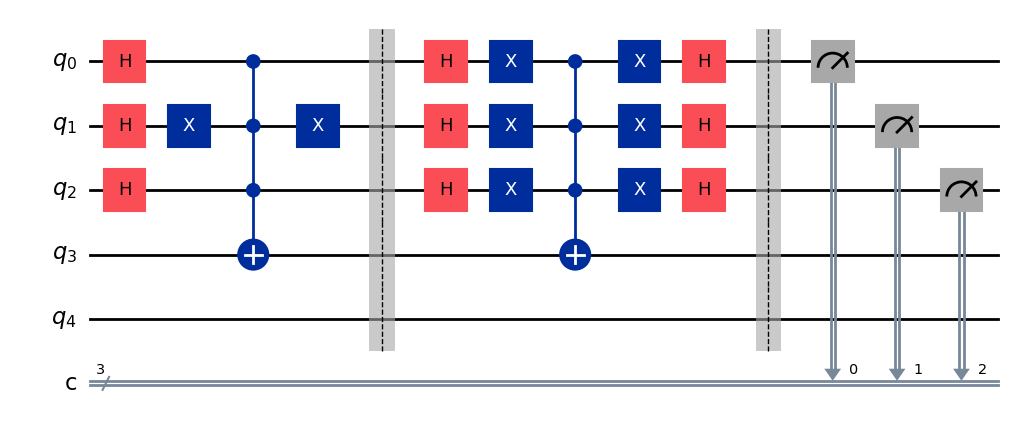


Measurement Results:


In [51]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def grover_oracle(n_data, target_state):
    n_total = n_data + 2  # data + 2 ancilla
    qc = QuantumCircuit(n_total)
    # Flip qubits for '0' bits in target_state
    for idx, bit in enumerate(target_state):
        if bit == '0':
            qc.x(idx)
    # Multi-controlled X (Toffoli) using ancilla qubits
    qc.mcx(control_qubits=list(range(n_data)),
           target_qubit=n_data,
           ancilla_qubits=[n_data+1],
           mode='recursion')
    # Uncompute the X gates
    for idx, bit in enumerate(target_state):
        if bit == '0':
            qc.x(idx)
    qc.barrier()  # Add barrier after oracle
    return qc

def grover_diffusion(n_data):
    n_total = n_data + 2
    qc = QuantumCircuit(n_total)
    # Hadamard and X
    for q in range(n_data):
        qc.h(q)
        qc.x(q)
    # Multi-controlled X (Toffoli)
    qc.mcx(control_qubits=list(range(n_data)),
           target_qubit=n_data,
           ancilla_qubits=[n_data+1],
           mode='recursion')
    # Hadamard and X again
    for q in range(n_data):
        qc.x(q)
        qc.h(q)
    qc.barrier()  # Add barrier after diffusion
    return qc

n_data = 3
target = '101'
n_total = n_data + 2
grover_circuit = QuantumCircuit(n_total, n_data)

# Initialize superposition
for q in range(n_data):
    grover_circuit.h(q)

# Apply Grover iteration
grover_circuit.compose(grover_oracle(n_data, target), inplace=True)
grover_circuit.compose(grover_diffusion(n_data), inplace=True)

# Measurement
grover_circuit.measure(range(n_data), range(n_data))

# Display circuit with visual separation
print("Grover's Algorithm Circuit with barriers to distinguish oracle and diffusion:")
display(grover_circuit.draw('mpl', fold=-1))

# Simulate and plot results
simulator = AerSimulator()
compiled = transpile(grover_circuit, simulator)
job = simulator.run(compiled, shots=1024)
result = job.result()
counts = result.get_counts()
print("\nMeasurement Results:")
plot_histogram(counts)
plt.show()


**Deutsch-Jozsa Algorithm - Query (promise) problem**

Deutsch-Jozsa Circuit (constant oracle):


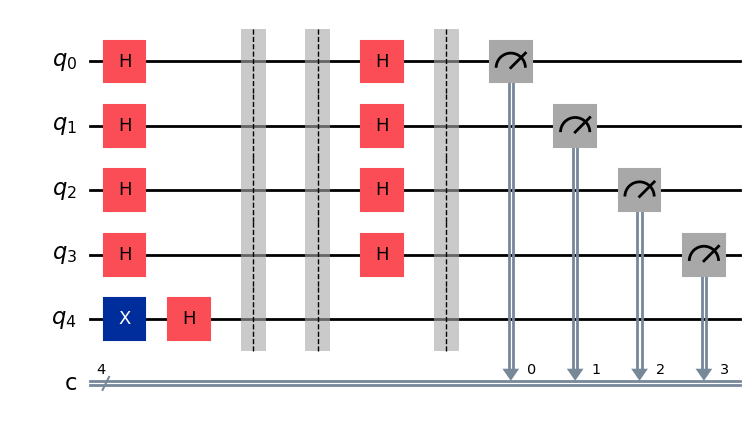


Measurement Results:


In [52]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def deutsch_jozsa_oracle(n, oracle_type='balanced'):
    """
    Returns a Deutsch-Jozsa oracle as a QuantumCircuit.
    n: number of input qubits (not counting the output qubit)
    oracle_type: 'balanced' or 'constant'
    """
    qc = QuantumCircuit(n+1)
    if oracle_type == 'constant':
        # Constant oracle: do nothing (always 0), or flip output (always 1)
        # Here, we do nothing (f(x)=0)
        pass
    elif oracle_type == 'balanced':
        # Balanced oracle: flip output for half the inputs
        # Example: flip output if first input qubit is 1
        qc.cx(0, n)
    else:
        raise ValueError("oracle_type must be 'balanced' or 'constant'")
    qc.barrier()
    return qc

def deutsch_jozsa_circuit(n, oracle_type='balanced'):
    qc = QuantumCircuit(n+1, n)
    # Initialize output qubit to |1>
    qc.x(n)
    # Hadamard on all qubits
    for q in range(n+1):
        qc.h(q)
    qc.barrier()
    # Oracle
    qc.compose(deutsch_jozsa_oracle(n, oracle_type), inplace=True)
    # Hadamard on input qubits
    for q in range(n):
        qc.h(q)
    qc.barrier()
    # Measure input qubits
    qc.measure(range(n), range(n))
    return qc

# Parameters
n = 4  # Number of input qubits

# Choose oracle type: 'balanced' or 'constant'
oracle_type = 'constant'  # Try 'constant' as well

# Build and display circuit
dj_circuit = deutsch_jozsa_circuit(n, oracle_type)
print(f"Deutsch-Jozsa Circuit ({oracle_type} oracle):")
display(dj_circuit.draw('mpl', fold=-1))

# Simulate
simulator = AerSimulator()
compiled = transpile(dj_circuit, simulator)
job = simulator.run(compiled, shots=1024)
counts = job.result().get_counts()

# Plot results
print("\nMeasurement Results:")
plot_histogram(counts)
plt.show()


**Bernstein-Vazirani Algorithm - Secret string query**

the secret string output from counts will be exactly inverted because of qiskit's qubit ordering which considers the given input bitstring from the rightmost being the topmost qubit in the ordering. this is very easy to reverse order using this code:

```
# for i in range(n-1, -1, -1):
```
but I am retaining the original code so the reader can understand qiskit qubit ordering.


Bernstein-Vazirani Circuit for secret string '100':


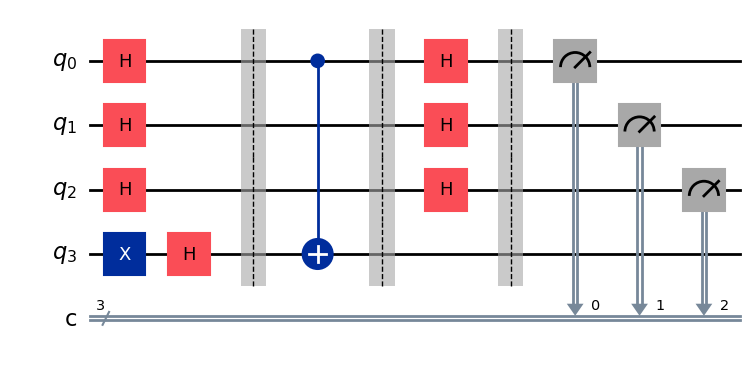


Measurement Results:


In [53]:
def bv_oracle(secret_string):
    """
    Returns a Bernstein-Vazirani oracle circuit for a given secret string.
    secret_string: str of '0' and '1' (e.g. '1011')
    """
    n = len(secret_string)
    qc = QuantumCircuit(n+1)
    for i, bit in enumerate(secret_string):
        if bit == '1':
            qc.cx(i, n)  # Control on qubit i, target on output qubit
    qc.barrier()
    return qc

def bernstein_vazirani_circuit(secret_string):
    n = len(secret_string)
    qc = QuantumCircuit(n+1, n)
    # Step 1: Initialize output qubit to |1>
    qc.x(n)
    # Step 2: Hadamard on all qubits
    for q in range(n+1):
        qc.h(q)
    qc.barrier()
    # Step 3: Oracle
    qc.compose(bv_oracle(secret_string), inplace=True)
    # Step 4: Hadamard on input qubits
    for q in range(n):
        qc.h(q)
    qc.barrier()
    # Step 5: Measure input qubits
    qc.measure(range(n), range(n))
    return qc

# Example: secret string '10110' (5 bits)
secret = '100'
bv_circuit = bernstein_vazirani_circuit(secret)
print(f"Bernstein-Vazirani Circuit for secret string '{secret}':")
display(bv_circuit.draw('mpl', fold=-1))

# Simulate
simulator = AerSimulator()
compiled = transpile(bv_circuit, simulator)
job = simulator.run(compiled, shots=1024)
counts = job.result().get_counts()

# Plot results
print("\nMeasurement Results:")
plot_histogram(counts)
plt.show()


**Quantum Phase Estimation**

*Quantum Phase estimation of a T gate with 3 counting qubits*

Quantum Phase Estimation Circuit:


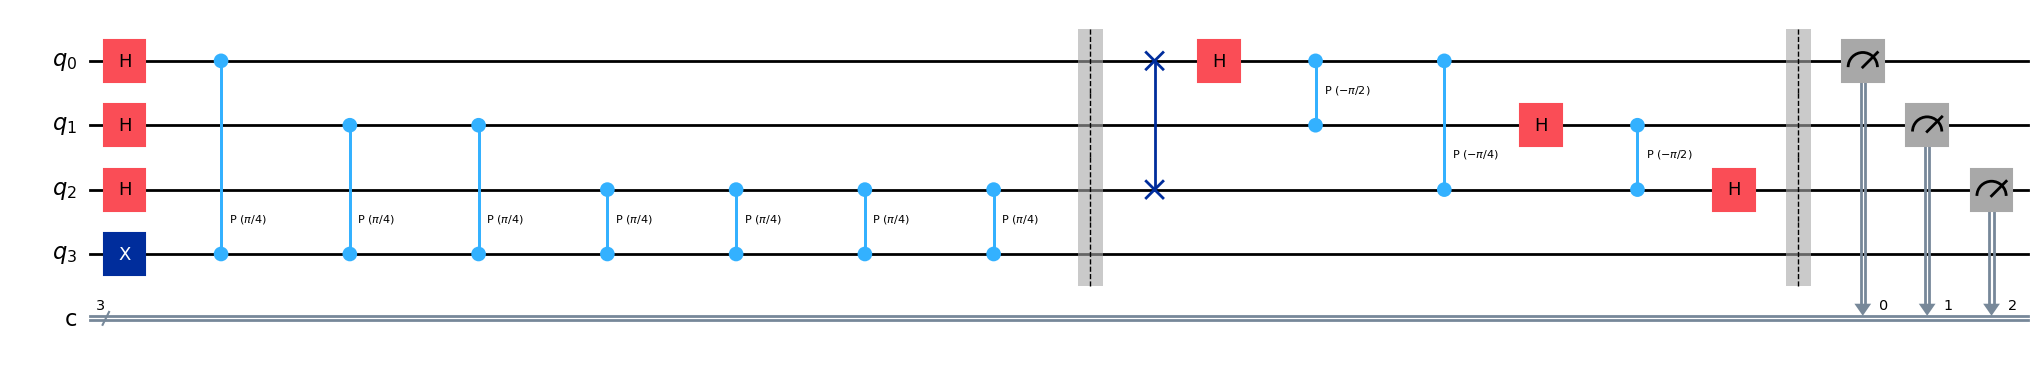


Measurement Results:
Estimated phase: θ = 0.1250 (True: 0.125)


In [54]:
def inverse_qft(qc, n_qubits):
    """Inverse QFT without final swaps"""
    for qubit in range(n_qubits//2):
        qc.swap(qubit, n_qubits-qubit-1)
    for target in range(n_qubits):
        qc.h(target)
        for control in range(target+1, n_qubits):
            angle = -np.pi / (2**(control - target))
            qc.cp(angle, control, target)

# Parameters
num_counting_qubits = 3
phase_angle = np.pi/4  # For T-gate (θ=1/8)

# Create QPE circuit
qpe = QuantumCircuit(num_counting_qubits + 1, num_counting_qubits)

# 1. Initialize eigenstate |1> on target
qpe.x(num_counting_qubits)

# 2. Hadamard on counting qubits
for qubit in range(num_counting_qubits):
    qpe.h(qubit)

# 3. Controlled unitary applications (T-gate powers)
for control_qubit in range(num_counting_qubits):
    exponent = 2**control_qubit
    for _ in range(exponent):
        qpe.cp(phase_angle, control_qubit, num_counting_qubits)

# 4. Inverse QFT on counting qubits
qpe.barrier()
inverse_qft(qpe, num_counting_qubits)
qpe.barrier()

# 5. Measurement
qpe.measure(range(num_counting_qubits), range(num_counting_qubits))

# Display circuit
print("Quantum Phase Estimation Circuit:")
display(qpe.draw('mpl', fold=-1))

# Simulate
simulator = AerSimulator()
compiled = transpile(qpe, simulator)
job = simulator.run(compiled, shots=1024)
counts = job.result().get_counts()

# Plot results
print("\nMeasurement Results:")
plot_histogram(counts)
plt.show()

# Calculate estimated phase
most_probable = max(counts, key=counts.get)
phase_estimate = int(most_probable, 2) / (2**num_counting_qubits)
print(f"Estimated phase: θ = {phase_estimate:.4f} (True: 0.125)")


**Simon's Algorithm**

Simon's Algorithm Circuit:


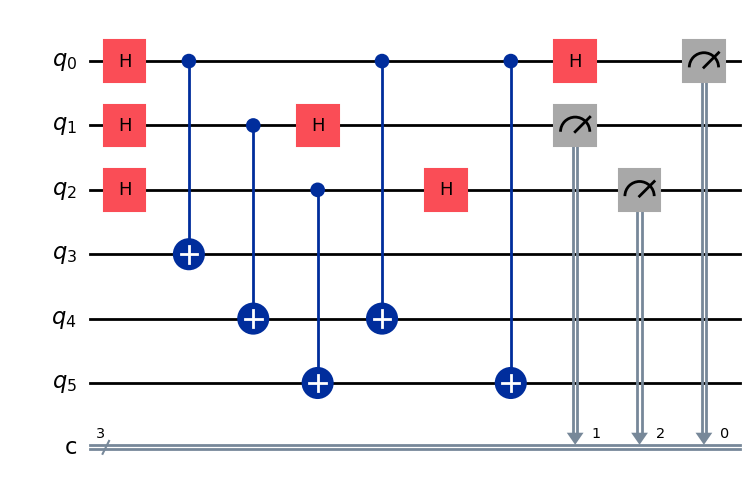


Measurement Results:

Secret string guess: 001
Actual secret: 110
Match: False


In [66]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np

# Configuration
SECRET_STRING = '110'  # Secret bitstring to find
N = len(SECRET_STRING)  # Number of input qubits

def simon_oracle():
    """Creates Simon oracle for secret string '110'"""
    qc = QuantumCircuit(2*N)
    # Implement f(x) = f(x⊕s) mapping
    qc.cx(0, 3)
    qc.cx(1, 4)
    qc.cx(2, 5)
    qc.cx(0, 4)
    qc.cx(0, 5)
    return qc

# Full Simon's algorithm circuit
def simon_circuit():
    qc = QuantumCircuit(2*N, N)
    # Initialize input superposition
    for i in range(N):
        qc.h(i)
    # Apply oracle
    qc.compose(simon_oracle(), inplace=True)
    # Hadamard and measure
    for i in range(N):
        qc.h(i)
    qc.measure(range(N), range(N))
    return qc

# Create and display circuit
circuit = simon_circuit()
print("Simon's Algorithm Circuit:")
display(circuit.draw('mpl', fold=-1))

# Simulate
simulator = AerSimulator()
compiled = transpile(circuit, simulator)
job = simulator.run(compiled, shots=100)
counts = job.result().get_counts()

# Plot results
print("\nMeasurement Results:")
plot_histogram(counts)
plt.show()

# Fixed classical post-processing with GF(2) Gaussian elimination
def gf2_solve_simon(measurements, n):
    """Solves y·s = 0 mod 2 using Gaussian elimination over GF(2)"""
    # Build matrix from measurements
    equations = []
    for bitstring in measurements:
        if int(bitstring, 2) != 0:
            equations.append([int(b) for b in bitstring])

    # Create coefficient matrix
    A = np.array(equations, dtype=int) if equations else np.zeros((0, n))

    # Gaussian elimination over GF(2)
    rows, cols = A.shape
    for r in range(min(rows, cols)):
        # Find pivot
        pivot = r
        while pivot < rows and A[pivot, r] == 0:
            pivot += 1
        if pivot >= rows:
            continue

        # Swap rows
        if pivot != r:
            A[[r, pivot]] = A[[pivot, r]]

        # Eliminate
        for i in range(r+1, rows):
            if A[i, r] == 1:
                A[i] = (A[i] + A[r]) % 2

    # Back substitution
    s = np.zeros(n, dtype=int)
    free_vars = list(range(n))
    for r in range(min(rows, cols)-1, -1, -1):
        pivot_col = np.where(A[r] == 1)[0]
        if len(pivot_col) > 0:
            pivot_col = pivot_col[0]
            s[pivot_col] = 0  # Set pivot variable
            for c in range(pivot_col+1, n):
                s[pivot_col] = (s[pivot_col] + A[r, c]*s[c]) % 2
            s[pivot_col] = (s[pivot_col] + 1) % 2  # For non-trivial solution
            free_vars.remove(pivot_col)

    # Set free variables to 0
    for col in free_vars:
        s[col] = 0

    return ''.join(map(str, s))

# Find secret string
secret_guess = gf2_solve_simon(counts.keys(), N)
print(f"\nSecret string guess: {secret_guess}")
print(f"Actual secret: {SECRET_STRING}")
print("Match:", secret_guess == SECRET_STRING)
